Реализация метода Нелдера-Мида

In [169]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt

Пусть нам дана некоторая векторная функция в $\mathbb{R}^2$. 

In [170]:
def test_func(coord):
    x = coord[0]
    y = coord[1]
    return np.sin(y) * np.exp((1 - np.cos(x)) ** 2) + \
         + np.cos(x) * np.exp((1 - np.sin(y)) ** 2) + \
         + (x - y) ** 2

Исследуем эту функцию. Построим график с линиями уровня. Можно провести прямую, которая проходит через некоторые точки минимума.

In [171]:
n_points = 1000
u = np.linspace(-5, 15, n_points)
x, y = np.meshgrid(u, u)

x_line = u
y_line = u + 1.58

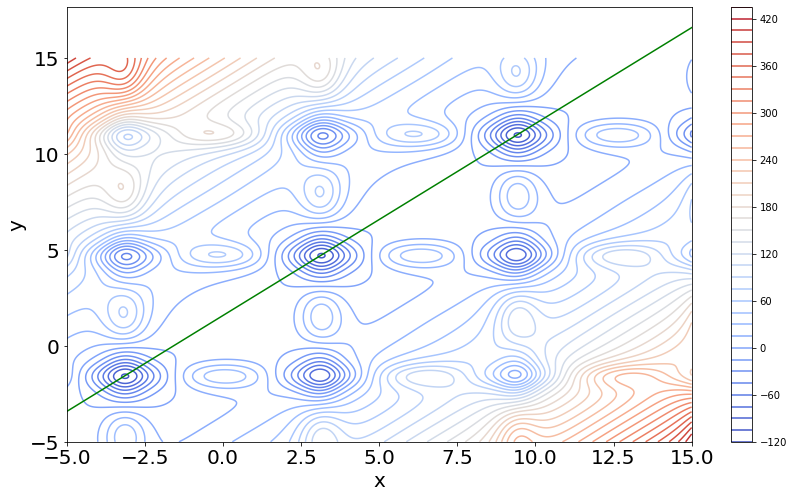

In [172]:
plt.figure(figsize = (14, 8))
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.xlabel("x", fontsize = 20)
plt.ylabel("y", fontsize = 20)

plt.contour(x, y, test_func([x, y]), 50, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.plot(x_line, y_line, c = "g")
plt.show()

Разобъём алгоритм на отдельные части.

Шаг 1. Сначала выберем начальные точки симплекса. Их будем пока что выбирать случайно.

In [173]:
iterations_num = 500

def GetRandCoord(bounds):
    return np.array([random.uniform(coord[0], coord[1]) for coord in bounds])

def GetInitialPoints(bounds):
    return np.array([GetRandCoord(bounds) for _ in range(len(bounds) + 1)])

Шаг 2. Отсортируем полученные точки по убыванию значения данной функции на полученных точках.

In [174]:
def SortPoints(points, func):
    values = np.array(list(map(func, points)))
    sorted_args = np.argsort(values)[::-1]
    return np.array(points)[sorted_args], np.array(values)[sorted_args]

Шаг 3. Найдём центр масс всех точек, не включая точку, с наибольшим значением функции.

In [175]:
def MassCentre(array):
    return np.mean(array)

Шаг 4. Найдём отражённую точку.

In [176]:
def GetReflected(x_central, x_highest, alpha):
    x_ref = (1 + alpha) * x_central - alpha * x_highest
    return x_ref

Шаг 5. Исследуем, насколько малое значение отраженной точки мы получили, относительно других точек.

In [177]:
def GetExtended(x_central, x_reflected, gamma):
    return (1 - gamma) * x_central + gamma * x_reflected

In [178]:
def GetShrinked(x_highest, x_central, betta):
    return betta * x_highest + (1 - betta) * x_central

In [179]:
def Homothety(sorted_array):
    return np.array([sorted_array[-1] + (x_i - sorted_array[-1]) / 2 for x_i in sorted_array])

In [180]:
def Nelder_Mead_algorithm( func, bounds, alpha = 1, betta = 0.5, gamma = 2, start_points = None):
    
    # 1. Initializing
    if start_points is None:
        points = GetInitialPoints(bounds)
    else:
        points = start_points
    all_simpleces = []
    all_deviation = []
    
    for iter in range(iterations_num):
        # 2. Sorting
        points, values = SortPoints(points, func)

        x_highest = points[0]
        x_g = points[1]
        x_lowest = points[-1]
        all_simpleces.append(np.array([x_highest, x_g, x_lowest]))

        f_highest = values[0]
        f_g = values[1]
        f_lowest = values[-1]

        # 3. Calculating centre
        x_central = MassCentre(points[1:])

        # 4. Reflecting
        x_reflected = GetReflected(x_central, x_highest, alpha)
        f_reflected = func(x_reflected)

        # 5. Exploring value of the function in the reflected point
        needs_compression = False
        if f_reflected < f_lowest:
            x_extended = GetExtended(x_central, x_reflected, gamma)
            f_extended = func(x_extended)

            if f_extended < f_reflected:
                points[0] = x_extended
            else:
                points[0] = x_reflected

        elif f_reflected < f_g:
            points[0] = x_reflected

        elif f_reflected < f_highest:
            x_reflected, x_highest = x_highest, x_reflected
            f_reflected, f_highest = f_highest, f_reflected
            points[0] = x_reflected
            needs_compression = True

        else:
            needs_compression = True

        if needs_compression:

            # 6. Compression
            x_shrinked = GetShrinked(x_highest, x_central, betta)
            f_shrinked = func(x_shrinked)

            # 7.Shrinked is good
            if f_shrinked < f_highest:
                points[0] = x_shrinked
            # 8. Global compression
            else:
                x_highest = x_lowest + (x_highest - x_lowest) / 2
                x_g = x_lowest + (x_g - x_lowest) / 2
                points = Homothety(points)

        # 9. Check variation
        deviation = np.mean(np.std( points, axis = 0))
        all_deviation.append(deviation)

    return np.array(all_simpleces), np.array(all_deviation)

In [181]:
bounds = [[0, 11], [0, 11]]

Несложно увидеть, что при разных начальных точках мы сходимся к разным точкам.

In [182]:
for _ in range(3):
    simpleces, deviation = Nelder_Mead_algorithm(test_func, bounds)
    print("Start points:", simpleces[0])
    print("Limit point:", np.mean(simpleces[-1], axis = 0), "Deviation:", deviation[-1], "\n")

Start points: [[ 4.24013346  9.47300079]
 [ 2.1294848   6.57965962]
 [ 3.36163728 10.10409118]]
Limit point: [8.10152683 5.39951033] Deviation: 0.5683472603492734 

Start points: [[ 5.82092882  0.76156246]
 [ 3.41789594 10.02613333]
 [ 7.9156026   9.03937934]]
Limit point: [ 9.32039733 10.9311485 ] Deviation: 7.251946429389431e-16 

Start points: [[ 2.30337232  8.81163708]
 [10.21219874  9.03932649]
 [ 5.09057462  3.69843802]]
Limit point: [ 9.44151938 10.95316028] Deviation: 0.0 



Возьмём сохранённый набор стартовых точек, чтобы проиллюстрировать, как работает алгоритм. На каждой итерации мы строим по определённым правилам все новые треугольники.

In [183]:
start_points_example = [[10.37601313, 1.14193934], \
                        [ 1.69628708, 7.65729426], \
                        [ 5.44145449, 10.09642523]]

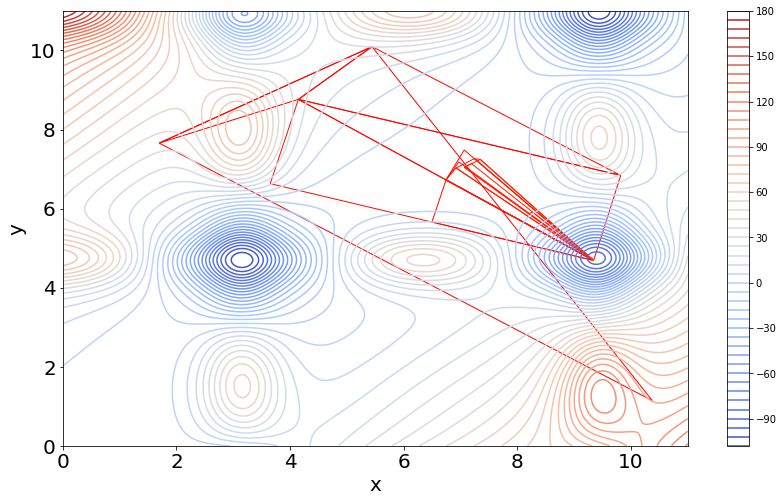

Сходится к точке:[9.33405228 4.69773939], отклонение: 2.564e-16


In [184]:
plt.figure(figsize = (14, 8))
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.xlabel("x", fontsize = 20)
plt.ylabel("y", fontsize = 20)

n_points = 1000
u = np.linspace(0, 11, n_points)
x, y = np.meshgrid(u, u)

simplex, deviation = Nelder_Mead_algorithm(test_func, bounds, start_points=start_points_example)
colors = plt.cm.hsv(np.linspace(0, 1, len(simplex)))

for idx in range(len(simplex)):
    points_ = simplex[idx]
    triangle = plt.Polygon(points_, closed=True, fill=False, color=colors[idx])
    ax = plt.gca()
    ax.add_patch(triangle)

plt.contour(x, y, test_func([x, y]), 50, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.show()

print(("Сходится к точке:{}, отклонение: {:.4}").format( points_[0], deviation[-1]))

Как видно из графика выше, треугольники действительно сходятся к точке минимума функции.

Исследуем скорость сходимости точек. Для этого посторим график зависимости дисперсии точек от номера итерации.

In [185]:
all_deviations = []
sample_size = 100
for _ in range(sample_size):
    sample, cur_dev = Nelder_Mead_algorithm(test_func, bounds)
    all_deviations.append(cur_dev)

y_list = np.mean(all_deviations, axis = 0)
x_list = np.array(range(len(sample))) + 1


Теперь построим график.

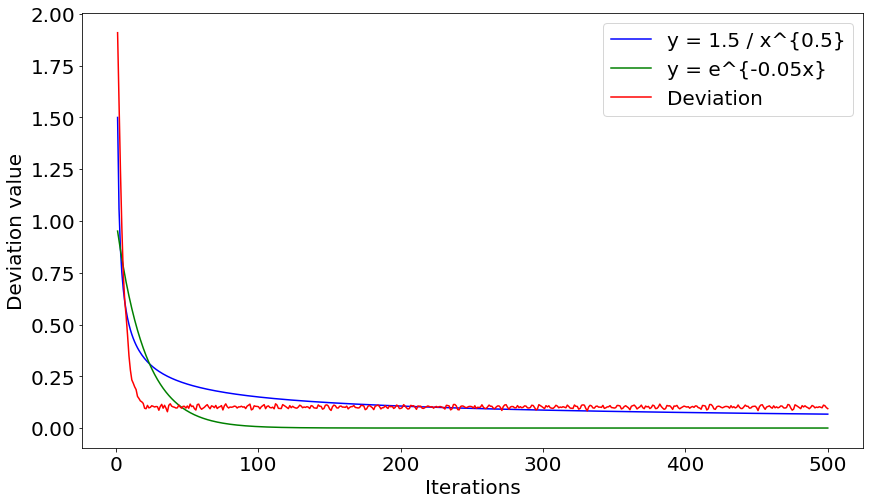

In [186]:
plt.figure(figsize = (14, 8))
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.xlabel("Iterations", fontsize = 20)
plt.ylabel("Deviation value", fontsize = 20)

y_test = list(map(lambda x: 1 * np.exp(-0.05*x), x_list))
y_test2 = list(map(lambda x: 1.5 / x ** 0.5, x_list))

plt.plot(x_list, y_test2, color = "blue", label=r'y = 1.5 / x^{0.5}')
plt.plot(x_list, y_test, color = "green", label=r'y = e^{-0.05x}')
plt.plot(x_list, y_list, color = "red", label = "Deviation")
plt.legend(prop={"size":20})
plt.show()

Как видно из графика, дисперсия падает довольно быстро, но медленне, чем экспонента. Похоже больше на степенную функцию. Таким образом, точки довольно близко сходятся друг к другу, хотя и не очень быстро.

Возьмем наш набор точек, который неоднократно нам пригождался, и покажем, что при одних и тех же начальных точках при разных значениях гиперпараметров алгоритм может сойтись к разным точкам.

In [187]:
alpha = 1
betta = 0.5
gamma = 2
diff = 3

print("Start points:", start_points_example)
param_simplex = []
for _ in range(5):
    simpleces, deviation = Nelder_Mead_algorithm(test_func, bounds, alpha = alpha, betta = betta, gamma = gamma, start_points = start_points_example)
    param_simplex.append(simpleces)
    print("Limit point:", np.mean(simpleces[-1], axis = 0), "\n")
    alpha, betta, gamma = diff * alpha, diff * betta, diff * gamma

Start points: [[10.37601313, 1.14193934], [1.69628708, 7.65729426], [5.44145449, 10.09642523]]
Limit point: [9.33405228 4.69773939] 

Limit point: [ 3.27801688 10.79772042] 

Limit point: [9.12342488 4.67988367] 

Limit point: [7.29191398 6.73849302] 

Limit point: [7.29191398 6.73849302] 



Как видим, в нашем случае мы сходимся к трём разным точкам, причем при строгом увеличении параметров мы попали в одну и ту же точку в первом и третьем случае.

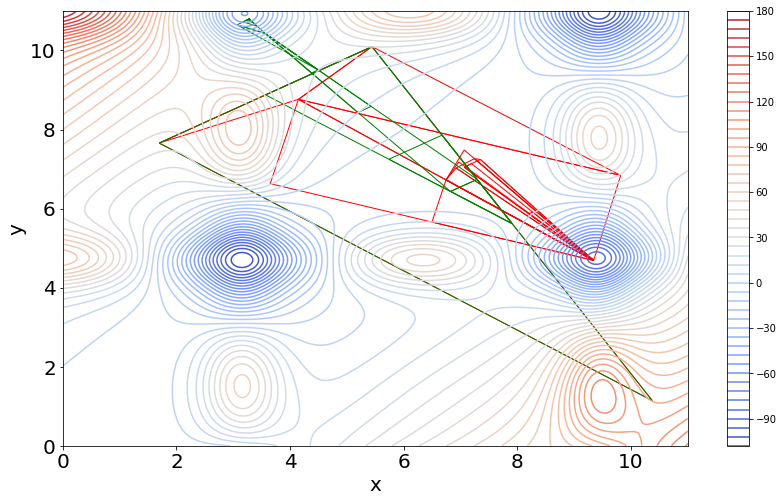

In [188]:
plt.figure(figsize = (14, 8))
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.xlabel("x", fontsize = 20)
plt.ylabel("y", fontsize = 20)

n_points = 1000
u = np.linspace(0, 11, n_points)
x, y = np.meshgrid(u, u)

param_simplex_ = [param_simplex[0], param_simplex[1]]
colors = ["r", "g"]

for idx in range(len(param_simplex_)):
    for simplex in param_simplex_[idx]:
        points_ = simplex
        triangle = plt.Polygon(points_, closed=True, fill=False, color=colors[idx])
        ax = plt.gca()
        ax.add_patch(triangle)

plt.contour(x, y, test_func([x, y]), 50, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.show()

Вывод. 

Как видно из приведенного выше кода и примеров, алгоритм действительно может находить точки минимума функции, впрочем, сходится не очень быстро.